# Mixture Density Network (MDN)

The goal of this notebook is to test the implementation of Gaussian MDN in jax.

In [2]:
%load_ext autoreload

%autoreload 2

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.33"

import numpy as np
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import sbibm
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload
from typing import Sequence, Callable, Any

import torch
import torch.utils.data as data

from normflow.utils import create_data_loader
from normflow.train import TrainerModule, TrainState

jax.config.update("jax_enable_x64", True)

2024-02-14 20:14:52.599551: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 20:14:52.599643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 20:14:52.626510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 20:14:54.956972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Simulation model

In this notebook, we use the `sbibm` library API to demonstrate how our network architectures work. The user can freely change the task though not all of them are supported.

In [3]:
sbibm.get_available_tasks()

['bernoulli_glm',
 'gaussian_linear',
 'gaussian_linear_uniform',
 'gaussian_mixture',
 'lotka_volterra',
 'sir',
 'slcp',
 'two_moons',
 'slcp_distractors',
 'bernoulli_glm_raw']

Let's first load a task, the corresponding prior and simulator and an observation and reference samples to assess the performance of our network.

In [4]:
task = sbibm.get_task('slcp')
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim = truth.shape[0]
dim_cond = observation.shape[1]
print(dim, dim_cond)

5 8


2024-02-14 20:15:02.013775: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


We then use the `torch.utils.data` to create datasets and embbed them in `DataLoader` structures from PyTorch. Those class should contain functions `__len__` and `__getitem__`. The function `create_data_loader` from `utils` then allows to build the data loaders with `jnp.ndarray` inside rather than `torch.Tensor`.

In [5]:
class SimulationDataset(data.Dataset):
    def __init__(self, num_points):
        super().__init__()
        self.thetas = prior(num_samples=num_points)
        self.xs = simulator(self.thetas)
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]

In [6]:
train_set = SimulationDataset(20000)
val_set = SimulationDataset(2000)
test_set = SimulationDataset(5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train=[True, False, False],
    batch_size=128
)

/feynman/home/dap/lcs/sg276684/.conda/envs/jax_sbi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Neural posterior estimation using Gaussian MDN

In this notebook, we will use Gaussian Mixture Density Network to estimate the target density. The network can be imported from `normflow.model` and inherit from the class `NDENetwork` that requires method `log_prob` and `samples` to respectively compute the log probability and sample from the learned density.

In [7]:
from normflow.model import MixtureDensityNetwork

In [8]:
NF_mdn = MixtureDensityNetwork(
    n_data=dim,
    n_components=3,
    layers=[128, 128],
    activation = jax.nn.silu
)

In [9]:
seed = jax.random.PRNGKey(0)
seed, init_seed = jax.random.split(seed)

params = NF_mdn.init(seed, jnp.zeros((1, dim_cond))) #Initialize the network

In [10]:
key = jax.random.PRNGKey(42)

batch_size = 54

thetas = prior(num_samples=batch_size)
xs = simulator(thetas)
thetas, xs = jnp.array(thetas), jnp.array(xs)

NF_mdn.apply(params, thetas, xs, method='log_prob') #To use other methods than the __call__
#the user should specify th ename of the method with the keyword 'method'.

Array([-2.83370361e+02, -1.71600780e+01, -1.48533239e+01, -1.21237503e+02,
       -2.94749565e+01, -2.45777481e+02, -1.69686279e+01, -1.80286999e+01,
       -1.51840992e+01, -1.61919346e+01, -2.21967246e+04, -1.67775803e+01,
       -2.53800621e+01, -2.18167362e+01, -3.84471875e+03, -1.13871946e+01,
       -2.11657543e+01, -4.98451538e+01, -7.44867935e+01, -2.22743568e+01,
       -1.68930073e+01, -4.72744446e+01, -1.01978674e+03, -1.91025677e+01,
       -3.82647583e+03, -7.36475159e+02, -8.32589188e+01, -1.53983383e+01,
       -4.40266998e+02, -2.26899948e+01, -1.93654785e+01, -2.53689728e+01,
       -2.67615147e+01, -1.95838757e+03, -6.74761047e+02, -5.68658142e+01,
       -1.21438618e+01, -4.52610596e+02, -1.28612622e+03, -3.76483307e+02,
       -9.44432068e+01, -3.33318787e+01, -1.42271099e+01, -2.20475197e+01,
       -3.82137985e+01, -2.47676697e+01, -1.38861217e+01, -1.05460400e+03,
       -9.27300358e+00, -2.83495972e+02, -7.68417664e+01, -3.59555573e+02,
       -5.46213226e+01, -

In [11]:
key, subkey = jax.random.split(key)

samples = NF_mdn.apply(params, observation, num_samples=100, key=key, method='sample')

In [12]:
samples.shape
#Here we sampled 100 samples from the target posterior conditioned on the observation

(100, 5)

## Using TrainerModule to train the Mixture Density Network

We implemented a `TrainerModule` that manages everything concerning training from the initialisation of the network to saving the optimized weights.
The class implements a default way to perform the training with specific callbacks, saving methods, etc... The user can easily modify the default approach by inheriting from TrainerModule and modifying or creating methods in this new class.
We here show how one can use `TrainerModule` to train a Gaussian Mixture Density Network.

In [13]:
class MDNTrainer(TrainerModule):#Inherits from TrainerModule to use the training loop
    def __init__(self, #Overload __init__ with hyperparameters of the network
                 n_data : int,
                 n_components : int,
                 layers : Sequence[int],  
                 activation : Callable,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=MixtureDensityNetwork,
                         model_hparams={
                            'n_data': n_data,
                            'n_components': n_components,
                            'layers': layers,
                            'activation': activation
                         },
                         **kwargs)
        self.trial = train_loader

    def create_functions(self): #The user has to create this function to initialize the train_step and test_step.
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, thetas, xs, method='log_prob'))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step

    def print_tabulate(self, exmp_input):
        pass

    def generate_config(self, logger_params): #Here you have to modify generate config
        super().generate_config(logger_params) #to save all hyperparameters correctly.
        sub_model_hparams = self.model_hparams.copy()
        sub_model_hparams['activation'] = sub_model_hparams['activation'].__name__
        self.config['model_hparams'] = sub_model_hparams
        


In [64]:
CHECKPOINT_PATH = '~/work/jax/notebooks/checkpoints/mdn' #Specify the path where you save the results of the training

trainer = MDNTrainer(n_data=dim, #Create your trainer
                            n_components=5,
                            layers=[128, 128],
                            activation=jax.nn.silu,
                            optimizer_hparams={'lr': 4e-3},
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(train_loader))[1], #beware of the training input.
                            check_val_every_epoch=5)

In [65]:
metrics = trainer.train_model( #It is as simple as calling this function now.
    train_loader, val_loader, test_loader=test_loader, num_epochs=100
)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

In [66]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: 5.096390724182129
Validation loss: 5.745051860809326
Test loss: 5.614610195159912


In [67]:
model = trainer.bind_model() #Freeze the network after training

In [68]:
key = jax.random.PRNGKey(42) #let's get our samples

samples = model.apply({'params': trainer.state.params}, observation, num_samples=10000, key=key, method='sample')

In [69]:
samples = samples.squeeze()

Let's compare to the true target density!

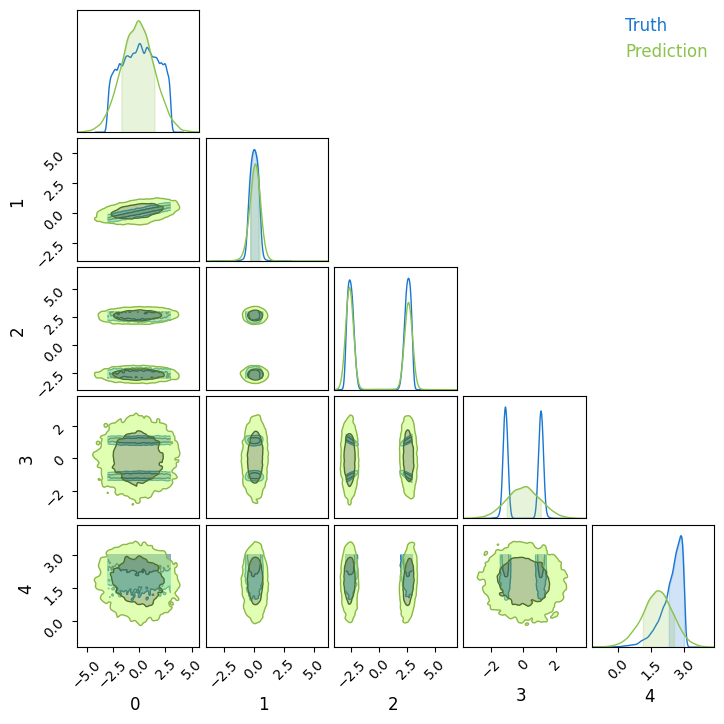

In [70]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

The posterior here is difficult to learn. It's highly non-linear with multimodality. By playing with the hyperparameters, it is possible to capture some of those features.

## Comparing training statistics with TensorBoard

The `TrainerModule` saved a file containing the statistics of training readable with TensorBoard which allows to check on the fly the evolution of the training. It is directly accessible from VSCode using the following command lines or by launching tensorboard directly using the command `Python: Launch Tensorboard` from VSCode.

In [71]:
%load_ext tensorboard
%tensorboard --logdir ~/work/jax/notebooks/checkpoints/mdn

## Optimizing hyperparameter choice with Optuna

In [14]:
import optuna

In [15]:
CHECKPOINT_PATH = '~/work/jax/notebooks/checkpoints/mdn'

In [16]:
def objective(trial):
    my_train_loader, my_val_loader = create_data_loaders(train_set, val_set,
                                                         train=[True, False],
                                                         batch_size=256)
    MDNTrainer(n_data=dim, #Create your trainer
                            n_components=trial.suggest_int('n_components', 3, 10),
                            layers=[128, 128],
                            activation=jax.nn.silu,
                            optimizer_hparams={
                                  'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True),
                                  'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True)
                              },
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(train_loader))[1], #beware of the training input.
                            check_val_every_epoch=5,
                            trial=trial)
    metrics = trainer.train_model(my_train_loader,
                                  my_val_loader,
                                  num_epochs=200)
    del trainer
    del my_train_loader, my_val_loader
    return metrics['val/acc']

In [17]:
study = optuna.create_study(
    study_name='mdn_slcp_hparam_search',
    storage=f'sqlite:///{CHECKPOINT_PATH}/optuna_hparam_search.db',
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)
study.optimize(objective, n_trials=25-len(study.trials), n_jobs=1)

OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)